In [41]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from scipy import stats as sc
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
import pickle
from random import randrange, choices

In [2]:
def variance_threshold_selector(data, threshold=0.7):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def kBestSelector(data, y, score_func = chi2, k = 5):
    selector = SelectKBest(score_func, k = k).fit(data, y)
    return data[data.columns[selector.get_support(indices=True)]]


In [13]:
suffix = "_UPDATED"

In [4]:
complete_season_path = "master_data_ver2/all_season_master_data_each_player_goals.csv"
complete_season_df = pd.read_csv(complete_season_path)

In [5]:
allCols = complete_season_df.columns
player_col = []
for col in allCols:
    if col.startswith("home_player") or col.startswith("away_player"):
        player_col.append(col)

In [6]:
player_col

['home_player_1_match_goal',
 'home_player_2_match_goal',
 'home_player_3_match_goal',
 'home_player_4_match_goal',
 'home_player_5_match_goal',
 'home_player_6_match_goal',
 'home_player_7_match_goal',
 'home_player_8_match_goal',
 'home_player_9_match_goal',
 'home_player_10_match_goal',
 'home_player_11_match_goal',
 'away_player_1_match_goal',
 'away_player_2_match_goal',
 'away_player_3_match_goal',
 'away_player_4_match_goal',
 'away_player_5_match_goal',
 'away_player_6_match_goal',
 'away_player_7_match_goal',
 'away_player_8_match_goal',
 'away_player_9_match_goal',
 'away_player_10_match_goal',
 'away_player_11_match_goal',
 'home_player_1_fpl_minutes',
 'home_player_1_fpl_goals',
 'home_player_1_fpl_assits',
 'home_player_1_fpl_cs',
 'home_player_1_fpl_points',
 'home_player_1_fpl_bonus',
 'home_player_1_fpl_cprice',
 'home_player_1_player_rating',
 'home_player_1_touches',
 'home_player_1_saves',
 'home_player_1_total_pass',
 'home_player_1_aerial_won',
 'home_player_1_form

In [7]:
player_stat_col = []
for col in player_col:
    if not col.endswith("match_goal"):
        splitted = col.split('_')
        stat = '_'.join(splitted[3:])
        if stat not in player_stat_col:
            player_stat_col.append(stat)

In [8]:
player_stat_col

['fpl_minutes',
 'fpl_goals',
 'fpl_assits',
 'fpl_cs',
 'fpl_points',
 'fpl_bonus',
 'fpl_cprice',
 'player_rating',
 'touches',
 'saves',
 'total_pass',
 'aerial_won',
 'formation_place',
 'accurate_pass',
 'total_tackle',
 'aerial_lost',
 'fouls',
 'yellow_card',
 'total_scoring_att',
 'man_of_the_match',
 'goals',
 'won_contest',
 'blocked_scoring_att',
 'goal_assist',
 'good_high_claim',
 'second_yellow',
 'red_card',
 'error_lead_to_goal',
 'last_man_tackle',
 'six_yard_block',
 'post_scoring_att',
 'att_pen_target',
 'penalty_save',
 'penalty_conceded',
 'clearance_off_line',
 'att_pen_goal',
 'att_pen_miss',
 'own_goals',
 'att_pen_post']

In [9]:
complete_season_df = complete_season_df[['match_id'] + player_col]                             

In [10]:
complete_season_df

,match_id,home_player_1_match_goal,home_player_2_match_goal,home_player_3_match_goal,home_player_4_match_goal,home_player_5_match_goal,home_player_6_match_goal,home_player_7_match_goal,home_player_8_match_goal,home_player_9_match_goal,...,away_player_11_six_yard_block,away_player_11_post_scoring_att,away_player_11_att_pen_target,away_player_11_penalty_save,away_player_11_penalty_conceded,away_player_11_clearance_off_line,away_player_11_att_pen_goal,away_player_11_att_pen_miss,away_player_11_own_goals,away_player_11_att_pen_post
0,829513,0,0,0,0,1,0,0,0,1,...,1.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,829514,0,0,0,0,0,1,0,0,0,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,829515,0,0,0,0,0,0,0,0,0,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,829516,0,0,0,0,0,0,0,0,1,...,0.00000,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,829517,0,0,0,0,0,0,0,0,1,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,829518,0,0,0,0,0,0,0,0,0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,829519,0,0,0,0,0,0,0,0,0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,829520,0,0,0,0,0,0,0,0,0,...,1.00000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,829521,0,0,0,0,0,0,0,0,0,...,0.00000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,829522,0,0,0,0,0,0,0,0,0,...,1.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_cols = ['match_id', 'scored'] + player_stat_col
goaler_df = pd.DataFrame(columns=df_cols)
index = 0
for _, row in complete_season_df.iterrows():
    match_id = int(row['match_id'])
    homeScorer, awayScorer = [], []
    homeNormies, awayNormies = [], []
    for i in range(1,12):
        home_match_goal_col = "home_player_"+str(i)+"_match_goal"
        away_match_goal_col = "away_player_"+str(i)+"_match_goal"
        if row[home_match_goal_col] >= 1:
            homeScorer.append(i)
        if row[away_match_goal_col] >= 1:
            awayScorer.append(i)
            
    for scorer in homeScorer:
        newScorerRow = []
        newScorerRow.append(match_id)
        newScorerRow.append(int(1))
        for stat in player_stat_col:
            colName = 'home_player_' + str(scorer) + "_" + stat
            newScorerRow.append(float(row[colName]))
        goaler_df.loc[index] = newScorerRow
        index += 1
        
        newPlebsRow = []
        newPlebsRow.append(match_id)
        newPlebsRow.append(int(0))
        tryAgain = True
        while tryAgain:
            plebNumber = randrange(1,12)
            if (plebNumber not in awayScorer) and (plebNumber not in awayNormies):
                tryAgain = False
                awayNormies.append(plebNumber)
        
        for stat in player_stat_col:
            colName = 'away_player_' + str(plebNumber) + "_" + stat
            newPlebsRow.append(float(row[colName]))
        goaler_df.loc[index] = newPlebsRow
        index += 1
    
    for scorer in awayScorer:
        newScorerRow = []
        newScorerRow.append(match_id)
        newScorerRow.append(int(1))
        for stat in player_stat_col:
            colName = 'away_player_' + str(scorer) + "_" + stat
            newScorerRow.append(float(row[colName]))
        goaler_df.loc[index] = newScorerRow
        index += 1
        
        newPlebsRow = []
        newPlebsRow.append(match_id)
        newPlebsRow.append(int(0))
        tryAgain = True
        while tryAgain:
            plebNumber = randrange(1,12)
            if (plebNumber not in homeScorer) and (plebNumber not in homeNormies):
                tryAgain = False
                homeNormies.append(plebNumber)
        
        for stat in player_stat_col:
            colName = 'home_player_' + str(plebNumber) + "_" + stat
            newPlebsRow.append(float(row[colName]))
        goaler_df.loc[index] = newPlebsRow
        index += 1
goaler_df.to_csv ("master_data_ver2/goal_prediction" + suffix + ".csv", index = None, header=True)       

In [ ]:
df_cols = ['match_id', 'scored'] + player_stat_col
goaler_df = pd.DataFrame(columns=df_cols)
index = 0
for _, row in complete_season_df.iterrows():
    match_id = int(row['match_id'])
    homeScorer, awayScorer = [], []
    homeNormies, awayNormies = [], []
    for i in range(1,12):
        home_match_goal_col = "home_player_"+str(i)+"_match_goal"
        away_match_goal_col = "away_player_"+str(i)+"_match_goal"
        if row[home_match_goal_col] >= 1:
            homeScorer.append(i)
        if row[away_match_goal_col] >= 1:
            awayScorer.append(i)
            
    for scorer in homeScorer:
        newScorerRow = []
        newScorerRow.append(match_id)
        newScorerRow.append(int(1))
        for stat in player_stat_col:
            colName = 'home_player_' + str(scorer) + "_" + stat
            newScorerRow.append(float(row[colName]))
        goaler_df.loc[index] = newScorerRow
        index += 1
        
        newPlebsRow = []
        newPlebsRow.append(match_id)
        newPlebsRow.append(int(0))
        tryAgain = True
        while tryAgain:
            plebNumber = randrange(1,12)
            if (plebNumber not in awayScorer) and (plebNumber not in awayNormies):
                tryAgain = False
                awayNormies.append(plebNumber)
        
        for stat in player_stat_col:
            colName = 'away_player_' + str(plebNumber) + "_" + stat
            newPlebsRow.append(float(row[colName]))
        goaler_df.loc[index] = newPlebsRow
        index += 1
    
    for scorer in awayScorer:
        newScorerRow = []
        newScorerRow.append(match_id)
        newScorerRow.append(int(1))
        for stat in player_stat_col:
            colName = 'away_player_' + str(scorer) + "_" + stat
            newScorerRow.append(float(row[colName]))
        goaler_df.loc[index] = newScorerRow
        index += 1
        
        newPlebsRow = []
        newPlebsRow.append(match_id)
        newPlebsRow.append(int(0))
        tryAgain = True
        while tryAgain:
            plebNumber = randrange(1,12)
            if (plebNumber not in homeScorer) and (plebNumber not in homeNormies):
                tryAgain = False
                homeNormies.append(plebNumber)
        
        for stat in player_stat_col:
            colName = 'home_player_' + str(plebNumber) + "_" + stat
            newPlebsRow.append(float(row[colName]))
        goaler_df.loc[index] = newPlebsRow
        index += 1
goaler_df.to_csv ("master_data_ver2/goal_prediction" + suffix + ".csv", index = None, header=True)       

In [47]:
df_cols = ['match_id', 'scored'] + player_stat_col
goaler_df = pd.DataFrame(columns=df_cols)
index = 0
k=400
players_goal_dict = {}
for _, row in complete_season_df.iterrows():
    match_id = int(row['match_id'])
    homeScorer, awayScorer = [], []
    homeNormies, awayNormies = [], []
    for i in range(1,12):
        home_match_goal_col = "home_player_"+str(i)+"_match_goal"
        away_match_goal_col = "away_player_"+str(i)+"_match_goal"
        if row[home_match_goal_col] >= 1:
            if row[home_match_goal_col] not in players_goal_dict:
                players_goal_dict[row[home_match_goal_col]] = []
            homeScorer.append((i, row[home_match_goal_col]))
        if row[away_match_goal_col] >= 1:
            if row[away_match_goal_col] not in players_goal_dict:
                players_goal_dict[row[away_match_goal_col]] = []
            awayScorer.append((i, row[away_match_goal_col]))
            
    for scorer, goal in homeScorer:
        newScorerRow = []
        newScorerRow.append(match_id)
        newScorerRow.append(int(goal))
        for stat in player_stat_col:
            colName = 'home_player_' + str(scorer) + "_" + stat
            newScorerRow.append(float(row[colName]))
        players_goal_dict[goal].append(newScorerRow)
        
    for scorer, goal in awayScorer:
        newScorerRow = []
        newScorerRow.append(match_id)
        newScorerRow.append(int(goal))
        for stat in player_stat_col:
            colName = 'away_player_' + str(scorer) + "_" + stat
            newScorerRow.append(float(row[colName]))
        players_goal_dict[goal].append(newScorerRow)
        
for i in range(1,4):
    choices_list = choices(players_goal_dict[i], k=k)
    for choice in choices_list:
        goaler_df.loc[index] = choice
        index += 1
#         newPlebsRow = []
#         newPlebsRow.append(match_id)
#         newPlebsRow.append(int(0))
#         tryAgain = True
#         while tryAgain:
#             plebNumber = randrange(1,12)
#             if (plebNumber not in homeScorer) and (plebNumber not in homeNormies):
#                 tryAgain = False
#                 homeNormies.append(plebNumber)
        
#         for stat in player_stat_col:
#             colName = 'home_player_' + str(plebNumber) + "_" + stat
#             newPlebsRow.append(float(row[colName]))
#         goaler_df.loc[index] = newPlebsRow
#         index += 1
goaler_df.to_csv ("master_data_ver2/goal_prediction_numeric" + suffix + ".csv", index = None, header=True)       

In [27]:
df_cols = ['match_id', 'scored'] + player_stat_col
goaler_df = pd.DataFrame(columns=df_cols)
index = 0
players_goal_dict = {}
for _, row in complete_season_df.iterrows():
    match_id = int(row['match_id'])
    homeScorer, awayScorer = [], []
    homeNormies, awayNormies = [], []
    for i in range(1,12):
        home_match_goal_col = "home_player_"+str(i)+"_match_goal"
        away_match_goal_col = "away_player_"+str(i)+"_match_goal"
        if row[home_match_goal_col] >= 1:
            if row[home_match_goal_col] not in players_goal_dict:
                players_goal_dict[row[home_match_goal_col]] = []
            players_goal_dict[row[home_match_goal_col]].append((match_id, 'home', i))
        if row[away_match_goal_col] >= 1:
            if row[away_match_goal_col] not in players_goal_dict:
                players_goal_dict[row[away_match_goal_col]] = []
            players_goal_dict[row[away_match_goal_col]].append((match_id, 'away', i))

In [40]:
len(players_goal_dict[1]), len(players_goal_dict[2]),len(players_goal_dict[3]),len(players_goal_dict[4]),len(players_goal_dict[5])

(2796, 302, 37, 6, 1)

In [35]:
players_goal_dict.keys()

dict_keys([1.0, 2.0, 3.0, 4.0, 5.0])

In [15]:
goal_pred_path = "master_data_ver2/goal_prediction_UPDATED.csv"
goal_pred_df = pd.read_csv(goal_pred_path)
goal_pred_df

,match_id,scored,fpl_minutes,fpl_goals,fpl_assits,fpl_cs,fpl_points,fpl_bonus,fpl_cprice,player_rating,...,six_yard_block,post_scoring_att,att_pen_target,penalty_save,penalty_conceded,clearance_off_line,att_pen_goal,att_pen_miss,own_goals,att_pen_post
0,829513.0,1.0,2287.00000,3.00000,0.00000,11.00000,120.00000,15.00000,6.100000,6.651000,...,0.000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0
1,829513.0,0.0,2771.00000,4.00000,12.00000,6.00000,132.00000,8.00000,5.600000,7.054412,...,1.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,829513.0,1.0,2007.00000,6.00000,6.00000,10.00000,116.00000,13.00000,8.800000,6.839000,...,0.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,829513.0,0.0,2823.00000,6.00000,7.00000,6.00000,128.00000,14.00000,5.500000,6.987838,...,0.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,829513.0,1.0,1173.00000,2.00000,1.00000,2.00000,42.00000,1.00000,4.600000,3.183548,...,1.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5,829513.0,0.0,729.00000,2.00000,1.00000,1.00000,36.00000,4.00000,6.300000,5.634706,...,1.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,829514.0,1.0,3202.00000,2.00000,2.00000,9.00000,91.00000,2.00000,4.700000,6.575946,...,1.000,0.000000,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0
7,829514.0,0.0,2481.00000,0.00000,3.00000,14.00000,132.00000,19.00000,6.200000,5.998286,...,0.000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
8,829514.0,1.0,3420.00000,4.00000,6.00000,17.00000,179.00000,13.00000,7.700000,7.253684,...,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9,829514.0,0.0,3415.00000,0.00000,4.00000,10.00000,118.00000,11.00000,4.800000,7.146579,...,0.000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0


In [16]:
# data_df = goal_pred_df.drop(columns=['match_id', 'fpl_minutes', 'fpl_goals', 'fpl_assits', 'fpl_cs', 'fpl_points', 'fpl_bonus', 'fpl_cprice'])
data_df = goal_pred_df.drop(columns=['match_id'])
X_unp = data_df.iloc[:,1:]
y = data_df.iloc[:,0]
X_unp.shape, y.shape

((6284, 39), (6284,))

In [17]:
X_v = variance_threshold_selector(X_unp, 0.7)
X_v.shape

(6284, 16)

In [18]:
X = kBestSelector(X_v, y, score_func = chi2, k = 6)

In [19]:
X.columns

Index(['fpl_minutes', 'fpl_goals', 'fpl_assits', 'fpl_points', 'fpl_bonus',
       'formation_place'],
      dtype='object')

14 0.7419955553082502


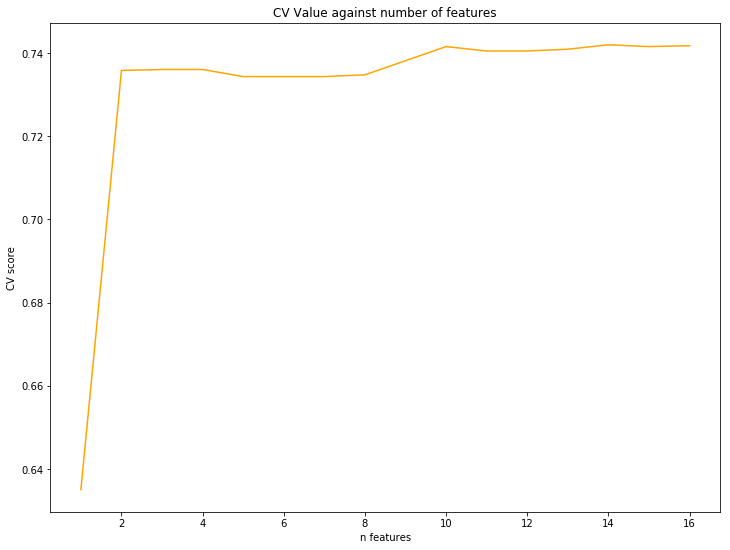

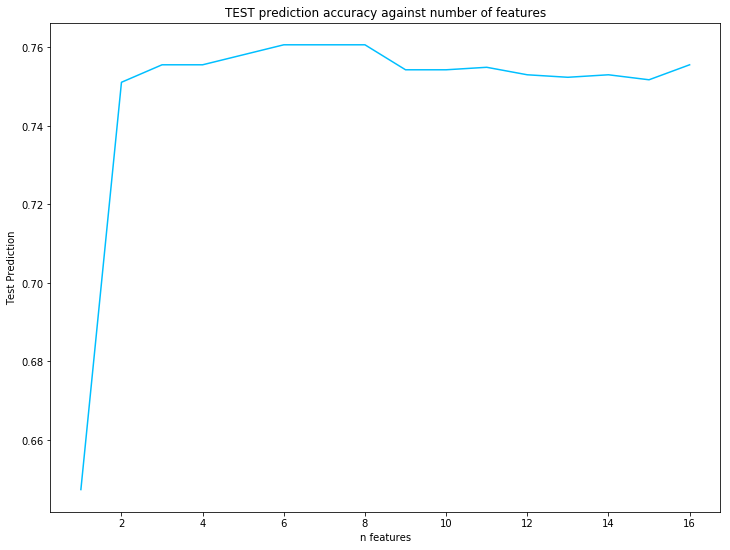

In [20]:
result_dict = {}
for k_v in range(1, X_v.shape[1]+1):
    X = kBestSelector(X_v, y, score_func = chi2, k = k_v)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train.values)
    X_test_std = stdsc.transform(X_test.values)
    log_reg = LogisticRegression(penalty='l1', C=0.1, solver = 'saga', multi_class='ovr', verbose = 0, n_jobs=-1, max_iter = 80000, random_state=20191028)
    log_reg.fit(X_train_std, y_train)
    cv_scores = cross_val_score(log_reg, X_train_std, y_train, cv=8, n_jobs=-1)
    result_dict[k_v] = (cv_scores, log_reg.score(X_train_std, y_train), np.mean(cv_scores), log_reg.score(X_test_std, y_test))
max = float("-inf")
fn = 0
for k,v in result_dict.items():
#     print(v, v[0])
    if v[2] > max:
        fn = k
        max = v[2]
print(fn, max)

x_ax = []
y_ax = []
test_pred = []
for k,v in result_dict.items():
    x_ax.append(k)
    y_ax.append(v[2])
    test_pred.append(v[3])
plt.figure(figsize=(12,9))
plt.title('CV Value against number of features')
plt.ylabel('CV score')
plt.xlabel('n features')
plt.plot(x_ax, y_ax, color='orange')
plt.show()

plt.figure(figsize=(12,9))
plt.title('TEST prediction accuracy against number of features')
plt.ylabel('Test Prediction')
plt.xlabel('n features')
plt.plot(x_ax, test_pred, color='deepskyblue')
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train.values)
X_test_std = stdsc.transform(X_test.values)

rbsc = RobustScaler()
X_train_rbs = rbsc.fit_transform(X_train.values)
X_test_rbs = rbsc.transform(X_test.values)

mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train.values)
X_test_mm = mm.transform(X_test.values)

In [118]:
log_reg = LogisticRegression(penalty='l2', C=0.001, solver = 'lbfgs', multi_class='ovr', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train, y_train)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


CV SCORES: [0.73714286 0.75047619 0.73714286 0.7352381  0.73282443 0.73664122
 0.6998088  0.73040153]
TRAINING Accuracy: 0.737
Average 8-Fold Training CV Score: 0.7324594967378454
TEST Accuracy: 0.740


In [119]:
log_reg = LogisticRegression(penalty='l1', C=0.1, solver = 'liblinear', multi_class='ovr', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train, y_train)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

[LibLinear]

c:\users\deni susanto\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CV SCORES: [0.74285714 0.74666667 0.73142857 0.74095238 0.73473282 0.72137405
 0.70554493 0.72848948]
TRAINING Accuracy: 0.735
Average 8-Fold Training CV Score: 0.7315057561199717
TEST Accuracy: 0.736


In [120]:
log_reg = LogisticRegression(penalty='l2', C=0.1, solver = 'liblinear', multi_class='ovr', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train, y_train)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

[LibLinear]

c:\users\deni susanto\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CV SCORES: [0.7447619  0.74857143 0.73142857 0.73714286 0.73091603 0.72137405
 0.70172084 0.73422562]
TRAINING Accuracy: 0.736
Average 8-Fold Training CV Score: 0.7312676626194681
TEST Accuracy: 0.735


In [22]:
log_reg = LogisticRegression(penalty='l1', C=0.1, solver = 'saga', multi_class='ovr', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train_std, y_train)
cv_scores = cross_val_score(log_reg, X_train_std, y_train, cv=8, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train_std, y_train))
print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test_std, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 16 epochs took 0 seconds
CV SCORES: [0.75762712 0.74237288 0.73389831 0.71816638 0.73005093 0.75551783
 0.75       0.74659864]
TRAINING Accuracy: 0.743
Average 8-Fold Training CV Score: 0.7417790111066151
TEST Accuracy: 0.756


In [23]:
# with open('pickle_models/scoring_prob_model.pickle', 'wb') as handle:
#     pickle.dump(log_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
# with open('pickle_models/scoring_prob_model_stdsc.pickle', 'wb') as handle:
#     pickle.dump(stdsc, handle, protocol=pickle.HIGHEST_PROTOCOL)